In [ ]:
!pip install librosa numpy scipy scikit-learn soundfile tensorflow matplotlib


In [ ]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import soundfile as sf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
def apply_dsp_compensation(audio_path):
    audio, sr = librosa.load(audio_path, sr=48000)

    # Compute FFT
    fft_audio = np.fft.fft(audio)
    freq = np.fft.fftfreq(len(fft_audio), 1/sr)

    # Keep only positive frequencies (0 to Nyquist)
    freq = freq[:len(freq)//2]
    magnitude_ratio = np.abs(fft_audio[:len(freq)]) / (np.abs(fft_audio[:len(freq)]).max() + 1e-8)

    # Create compensation filter (limit max gain to avoid extreme corrections)
    magnitude_response = 1 / (magnitude_ratio + 1e-8)
    magnitude_response[magnitude_response > 10] = 10

    # Ensure last gain value at Nyquist is valid
    freq = np.append(freq, sr/2)
    magnitude_response = np.append(magnitude_response, 1.0)

    # Design FIR filter
    num_taps = 513
    fir_filter = signal.firwin2(num_taps, freq / (sr/2), magnitude_response)

    # Apply FIR filter
    compensated_audio = signal.lfilter(fir_filter, 1, audio)

    # Save compensated audio
    dsp_output_path = os.path.join(output_folder, f"DSP_Compensated_{os.path.basename(audio_path)}")
    sf.write(dsp_output_path, compensated_audio, sr)

    return dsp_output_path, sr, audio, compensated_audio


In [ ]:
def extract_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=48000)  # Ensure 48kHz sample rate

    # Extract MFCCs & spectral features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)

    # Normalize features
    mfcc = mfcc / np.max(np.abs(mfcc))
    spectral_centroid = spectral_centroid / np.max(np.abs(spectral_centroid))
    spectral_bandwidth = spectral_bandwidth / np.max(np.abs(spectral_bandwidth))

    # Combine features into a single matrix
    return np.vstack((mfcc, spectral_centroid, spectral_bandwidth))


In [ ]:
def prepare_training_data(clean_files, distorted_files):
    X, Y = [], []

    # Define a fixed size for the extracted features (e.g., 22 rows, 500 columns)
    fixed_mfcc_rows = 20
    fixed_columns = 500  # Adjust this based on your feature size

    for clean_path, distorted_path in zip(clean_files, distorted_files):
        dsp_audio_path, sr, _, dsp_audio = apply_dsp_compensation(distorted_path)

        # Extract features
        clean_features = extract_features(clean_path)
        dsp_features = extract_features(dsp_audio_path)

        # Ensure all feature matrices are of the same size by padding or truncating
        clean_features = pad_or_truncate_features(clean_features, fixed_mfcc_rows, fixed_columns)
        dsp_features = pad_or_truncate_features(dsp_features, fixed_mfcc_rows, fixed_columns)

        # Append features
        X.append(dsp_features)
        Y.append(clean_features)

    # Convert lists into numpy arrays with consistent shapes
    X = np.array(X)
    Y = np.array(Y)

    # Add an extra axis to ensure compatibility for CNN input
    X = X[..., np.newaxis]
    Y = Y[..., np.newaxis]

    return X, Y

def pad_or_truncate_features(features, target_rows, target_columns):
    """
    Pad or truncate the feature matrix to have the target number of rows and columns.
    """
    # Pad the feature matrix if it's smaller than the target size
    if features.shape[1] < target_columns:
        padding_width = target_columns - features.shape[1]
        features = np.pad(features, ((0, 0), (0, padding_width)), mode='constant')

    # Truncate the feature matrix if it's larger than the target size
    if features.shape[1] > target_columns:
        features = features[:, :target_columns]

    # Pad or truncate rows to match target number of rows
    if features.shape[0] < target_rows:
        row_padding = target_rows - features.shape[0]
        features = np.pad(features, ((0, row_padding), (0, 0)), mode='constant')
    elif features.shape[0] > target_rows:
        features = features[:target_rows, :]

    return features


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define folder containing the audio files
audio_folder = "/content/"

# List all clean & distorted files
clean_files = ["/content/4_reference_sweep.wav",
    "/content/2_reference_sweep.wav",
    "/content/3_reference_sweep.wav",
    "/content/1_reference_sweep.wav",
     "/content/0_reference_sweep.wav"
]

distorted_files = [
     "/content/2_through_medium.wav",
    "/content/3_through_medium.wav",
    "/content/33_through_medium.wav",
     "/content/1_through_medium.wav",
 "/content/0_through_medium.wav"
]

# Ensure output folder exists
output_folder = "/content/processed/2"
os.makedirs(output_folder, exist_ok=True)


In [ ]:
def build_cnn_model(input_shape):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.mse, metrics=['mae'])
    return model



In [ ]:
def apply_hybrid_compensation(model_path, distorted_audio_path):
    # Apply DSP first
    dsp_audio_path, sr, distorted_audio, dsp_compensated_audio = apply_dsp_compensation(distorted_audio_path)

    # Load trained CNN model
    model = keras.models.load_model(model_path)

    # Extract features from DSP-compensated audio
    dsp_features = extract_features(dsp_audio_path)
    dsp_features = dsp_features[np.newaxis, ..., np.newaxis]  # Adding batch and channel dimensions

    # Predict the corrected features using the CNN
    predicted_features = model.predict(dsp_features)[0, ..., 0]

    # Convert predicted features back to a spectrogram using Griffin-Lim
    mel_spectrogram = librosa.db_to_power(predicted_features[:20])  # Using the first 20 MFCC coefficients
    reconstructed_audio = librosa.griffinlim(mel_spectrogram)  # Reconstruct the audio

    # Save the hybrid-compensated audio
    # Modified to extract filename before prepending 'Hybrid_Compensated_'
    file_name = os.path.basename(distorted_audio_path)
    hybrid_compensated_path = os.path.join(output_folder, f'Hybrid_Compensated_{file_name}')
    sf.write(hybrid_compensated_path, reconstructed_audio, sr)

    return hybrid_compensated_path, reconstructed_audio

In [ ]:
X_train, Y_train = prepare_training_data(clean_files, distorted_files)

# Build & train CNN model
input_shape = X_train.shape[1:]
model = build_cnn_model(input_shape)
model.fit(X_train, Y_train, epochs=10, batch_size=4)

# Save trained model
model_path = os.path.join(output_folder, "cnn_dsp_audio_compensation.h5")
model.save(model_path)
print(f"Model saved at {model_path}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 910ms/step - loss: 0.3054 - mae: 0.5135
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2465 - mae: 0.4473 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1456 - mae: 0.3003
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0685 - mae: 0.1668
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0456 - mae: 0.1104
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0438 - mae: 0.0992
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0432 - mae: 0.0962
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0433 - mae: 0.0956
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0432 - mae: 0.0956
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0420 - mae: 0.0937


Model saved at /content/processed/2/cnn_dsp_audio_compensation.h5


In [ ]:
def plot_audio_signals(clean_audio, distorted_audio, dsp_compensated_audio, hybrid_compensated_audio, sr):
    plt.figure(figsize=(10, 6))
    plt.subplot(4, 1, 1)
    librosa.display.waveshow(clean_audio, sr=sr, color='g')
    plt.title("Clean Audio Signal")

    plt.subplot(4, 1, 2)
    librosa.display.waveshow(distorted_audio, sr=sr, color='r')
    plt.title("Distorted Audio Signal")

    plt.subplot(4, 1, 3)
    librosa.display.waveshow(dsp_compensated_audio, sr=sr, color='b')
    plt.title("DSP Compensated Audio Signal")

    plt.subplot(4, 1, 4)
    librosa.display.waveshow(hybrid_compensated_audio, sr=sr, color='purple')
    plt.title("Hybrid Compensated Audio Signal")

    plt.tight_layout()
    plt.show()



In [ ]:
def plot_spectrograms(clean_audio, distorted_audio, dsp_compensated_audio, hybrid_compensated_audio, sr):
    plt.figure(figsize=(10, 8))

    # Plot clean spectrogram
    plt.subplot(2, 2, 1)
    D = librosa.amplitude_to_db(librosa.stft(clean_audio), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title('Clean Audio Spectrogram')

    # Plot distorted spectrogram
    plt.subplot(2, 2, 2)
    D = librosa.amplitude_to_db(librosa.stft(distorted_audio), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title('Distorted Audio Spectrogram')

    # Plot DSP-compensated spectrogram
    plt.subplot(2, 2, 3)
    D = librosa.amplitude_to_db(librosa.stft(dsp_compensated_audio), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title('DSP Compensated Spectrogram')

    # Plot hybrid-compensated spectrogram
    plt.subplot(2, 2, 4)
    D = librosa.amplitude_to_db(librosa.stft(hybrid_compensated_audio), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title('Hybrid Compensated Spectrogram')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


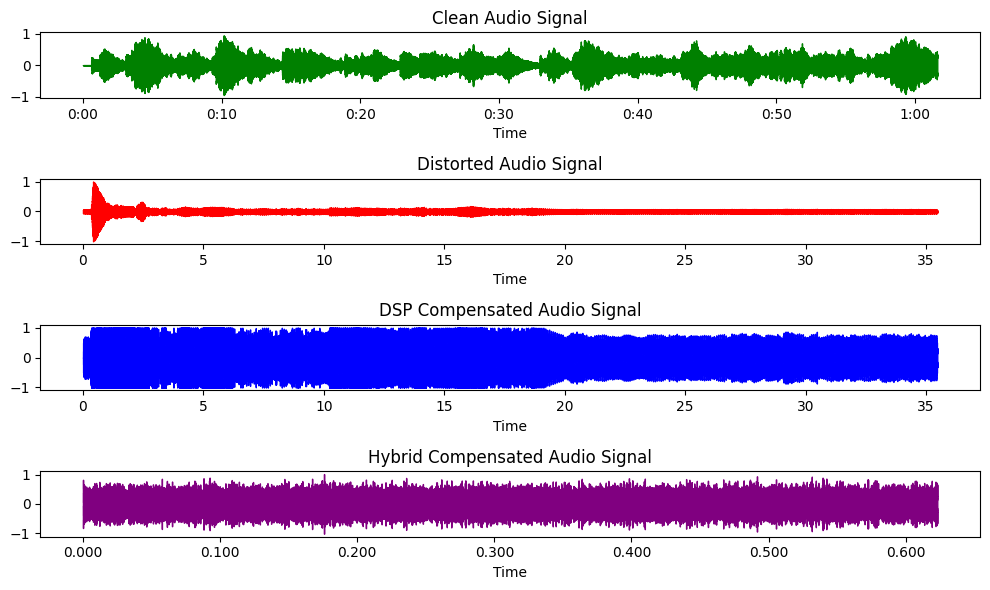

<ipython-input-85-a3c7f50bd4cf>:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(clean_audio), ref=np.max)
<ipython-input-85-a3c7f50bd4cf>:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(distorted_audio), ref=np.max)
<ipython-input-85-a3c7f50bd4cf>:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(dsp_compensated_audio), ref=np.max)
<ipython-input-85-a3c7f50bd4cf>:24: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(

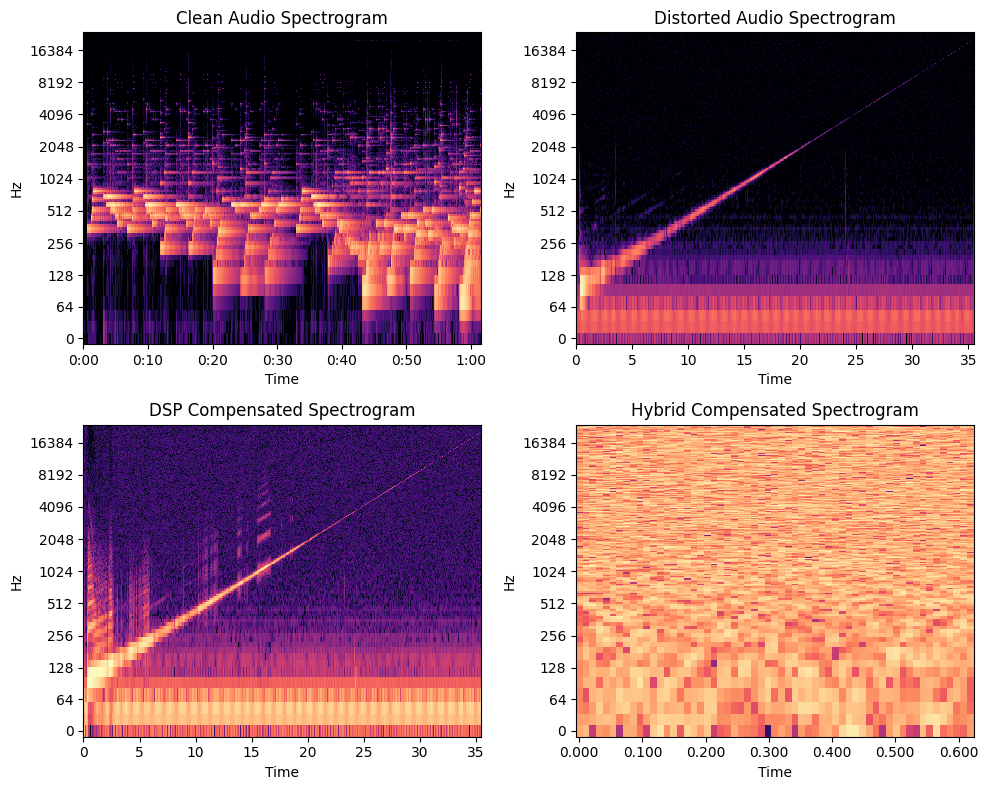

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


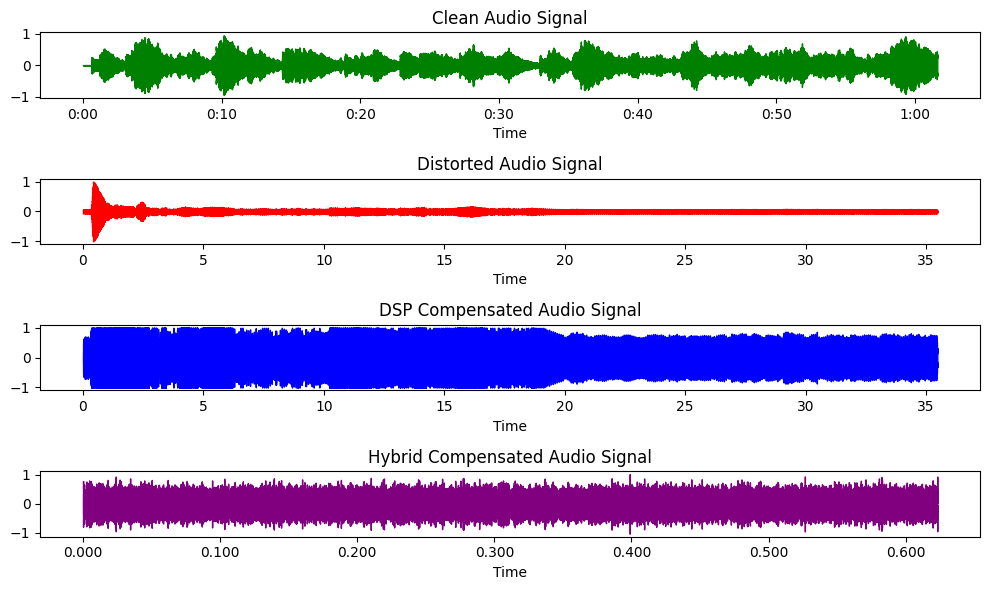

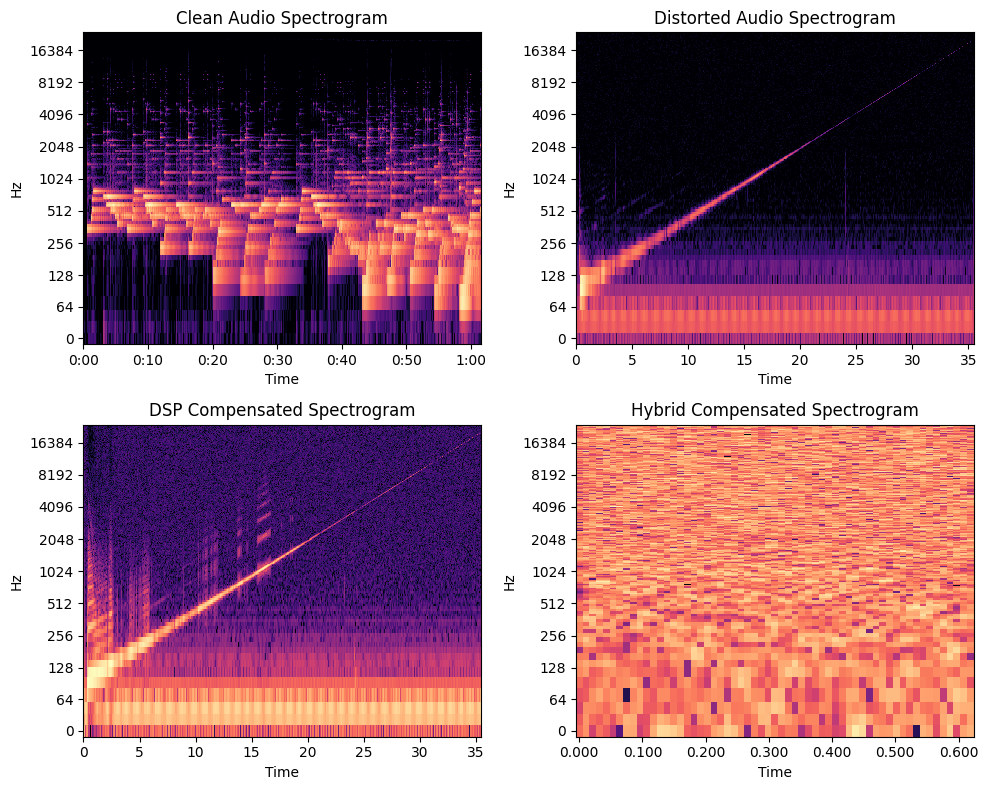

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


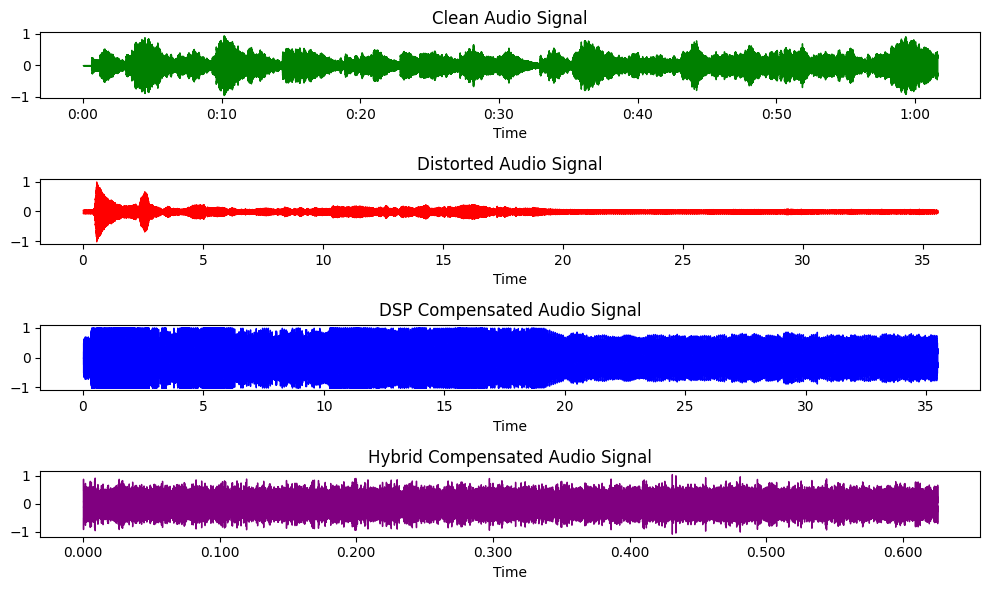

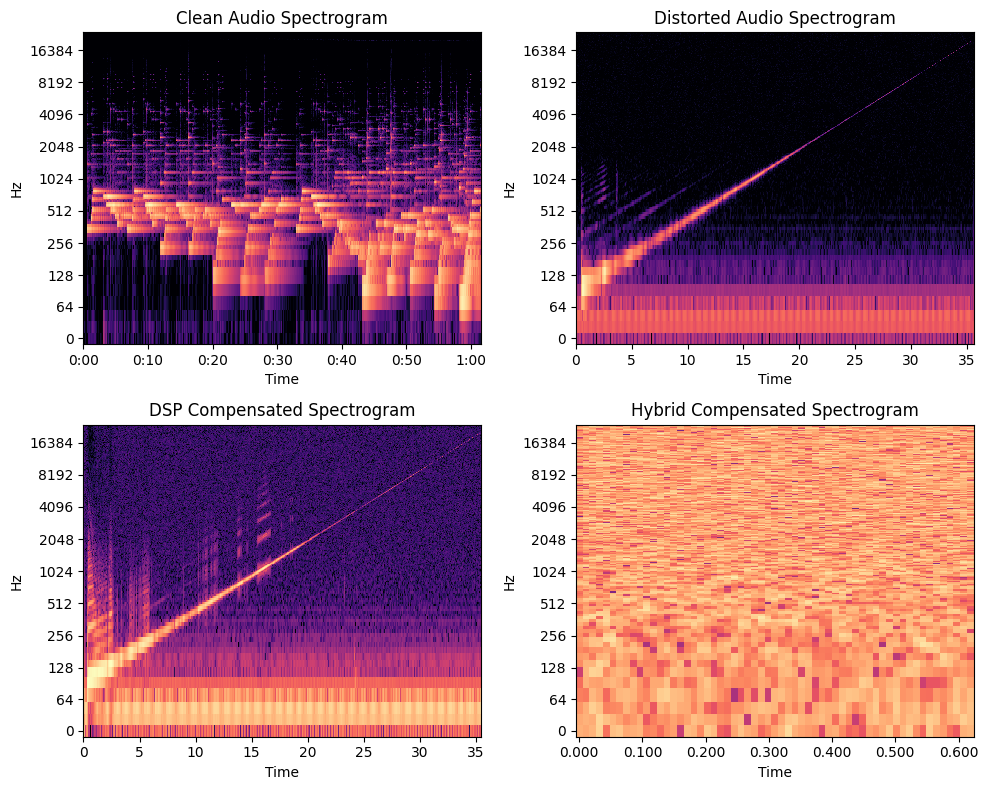

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


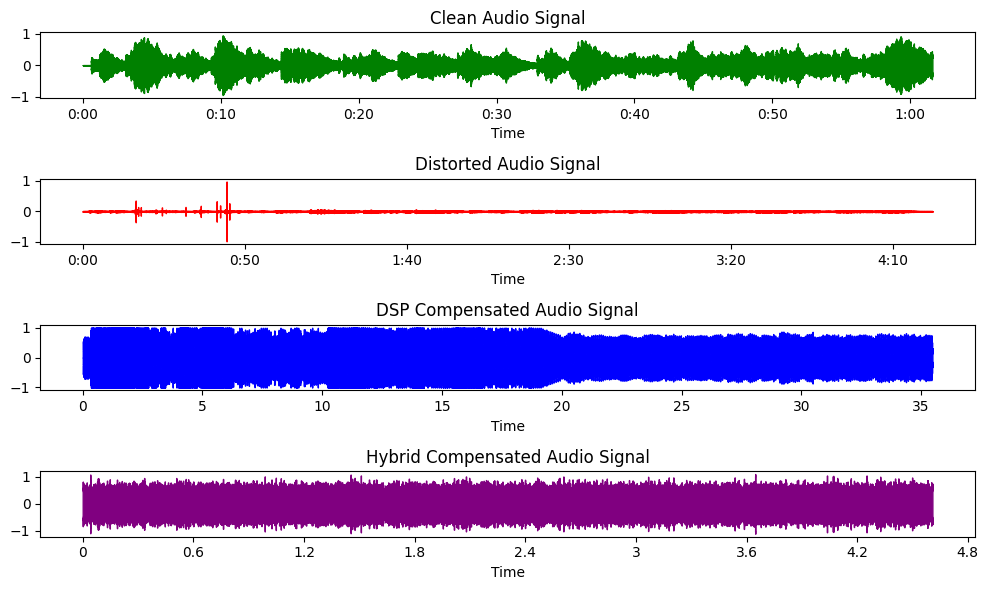

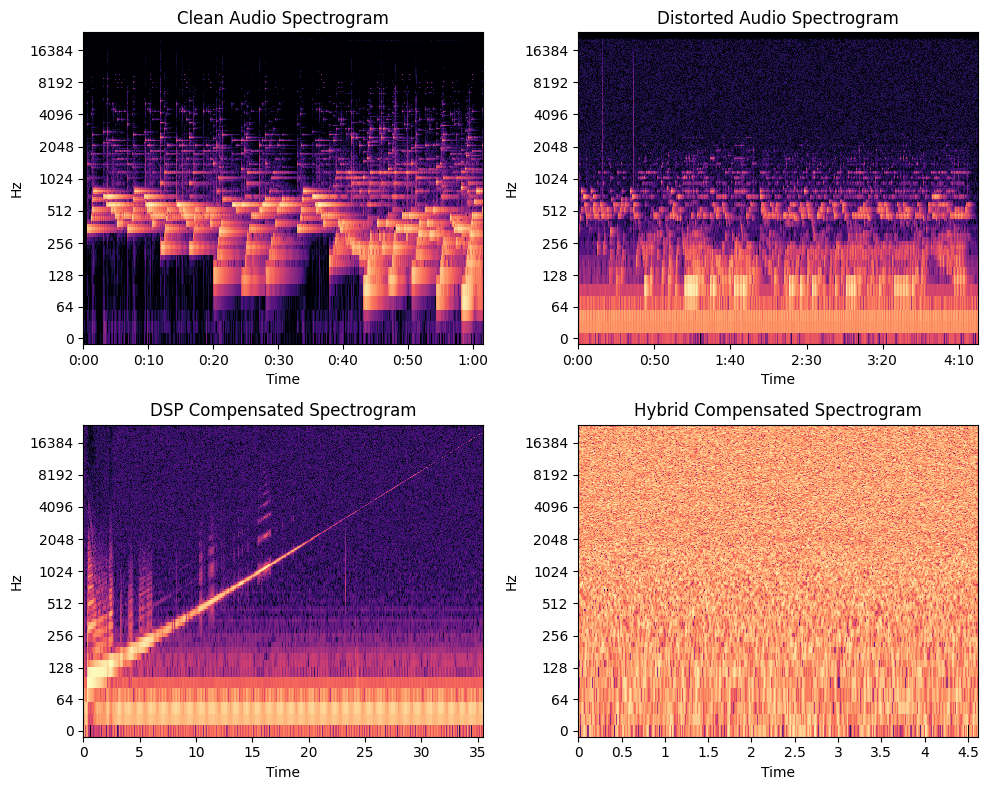

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


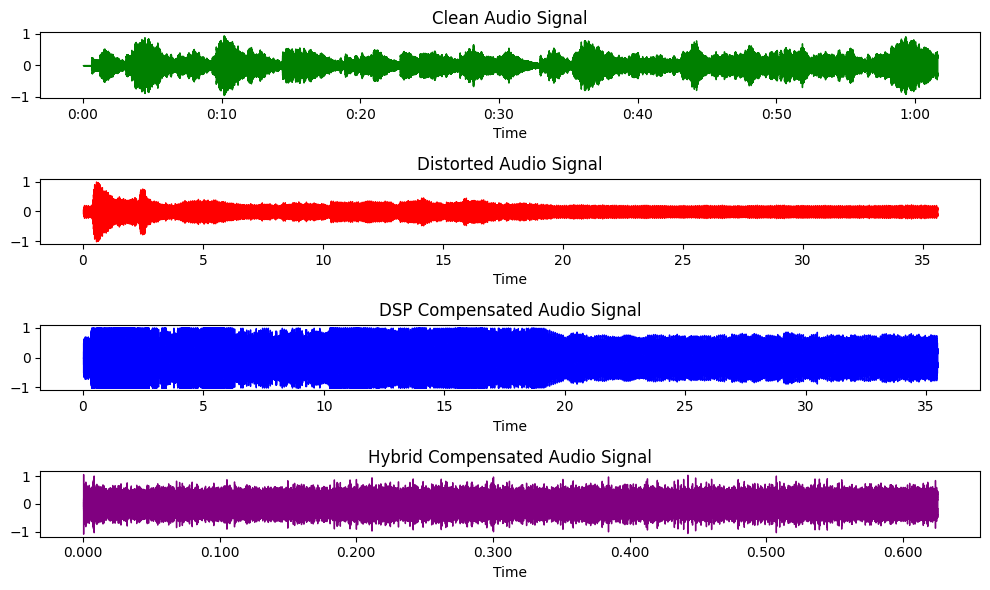

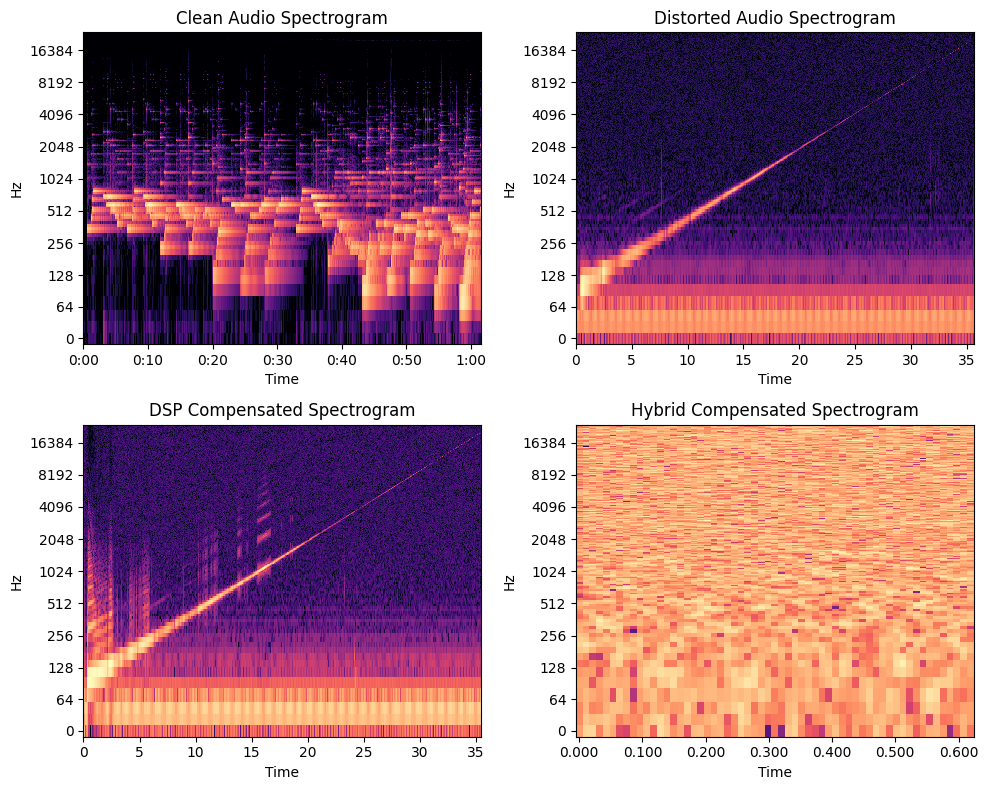

In [ ]:
# Example usage after training and compensation
for distorted_audio_path in distorted_files:
    hybrid_compensated_path, hybrid_compensated_audio = apply_hybrid_compensation(model_path, distorted_audio_path)

    # Load the clean audio for comparison
    clean_audio, sr = librosa.load(clean_files[0], sr=48000)
    distorted_audio, _ = librosa.load(distorted_audio_path, sr=48000)
    dsp_compensated_audio, _ = librosa.load(dsp_audio_path, sr=48000)

    # Plot waveform comparisons
    plot_audio_signals(clean_audio, distorted_audio, dsp_compensated_audio, hybrid_compensated_audio, sr)

    # Plot spectrogram comparisons
    plot_spectrograms(clean_audio, distorted_audio, dsp_compensated_audio, hybrid_compensated_audio, sr)
